Loading and Preprocessing

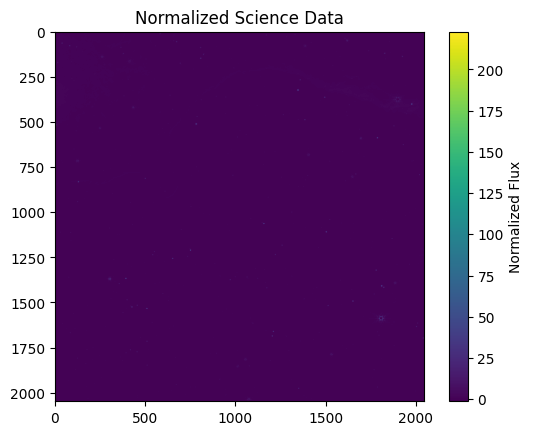

In [13]:
from astropy.io import fits
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load FITS file
def load_fits(file_path):
    with fits.open(file_path) as hdul:
        sci_data = hdul['SCI'].data  # Science data
        dq_data = hdul['DQ'].data  # Data quality flags
        err_data = hdul['ERR'].data  # Uncertainty data
        header = hdul[0].header  # Metadata
    
    # Mask invalid data based on DQ flags (e.g., ignoring bad pixels)
    sci_data[dq_data != 0] = np.nan
    return sci_data, err_data, header

# Normalize the data (ignoring NaN values)
def normalize_data(data):
    flattened = data.flatten()
    valid_data = flattened[~np.isnan(flattened)]
    mean, std = np.mean(valid_data), np.std(valid_data)
    normalized = (data - mean) / std
    return np.nan_to_num(normalized)  # Replace NaNs with 0

# Process the FITS file
file_path = "JWST_data.fits"  # Replace with your FITS file
sci_data, err_data, header = load_fits(file_path)
sci_data_normalized = normalize_data(sci_data)

# Visualize the normalized data
plt.imshow(sci_data_normalized, cmap="viridis")
plt.colorbar(label="Normalized Flux")
plt.title("Normalized Science Data")
plt.show()


Extracting features for Clustering and RF

In [14]:
def extract_features(data, region_size=50):
    """
    Divide the image into regions and compute mean flux per region.
    """
    rows, cols = data.shape
    features = []
    for i in range(0, rows, region_size):
        for j in range(0, cols, region_size):
            region = data[i:i + region_size, j:j + region_size]
            mean_flux = np.nanmean(region)  # Use nanmean to ignore NaNs
            features.append(mean_flux)
    return np.array(features).reshape(-1, 1)  # Reshape for sklearn models

features = extract_features(sci_data_normalized)


Clustering with K-means

/home/chloy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


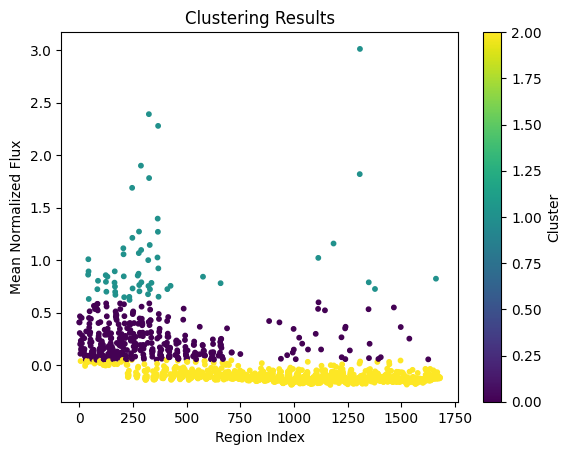

In [15]:
# Perform k-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features)

# Visualize the clusters
plt.scatter(range(len(features)), features, c=clusters, cmap="viridis", s=10)
plt.title("Clustering Results")
plt.xlabel("Region Index")
plt.ylabel("Mean Normalized Flux")
plt.colorbar(label="Cluster")
plt.show()
